<a href="https://colab.research.google.com/github/hudazama/CarvanaMasking/blob/master/Carvana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/carvana_graphics.png)

> **Background**

*   Carvana, an online used car startup, wants to superimpose cars on a variety of background
*   The aim of this challenge is to develop an algorithm that automatically removes the photo studio background 













In [1]:
!pip install kaggle --upgrade
!pip install imageio

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import imageio
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hudazama","key":"4a7b6208c35416dc85497ae8d716dbf9"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#download Carvana competition data into colab
!kaggle competitions download -c carvana-image-masking-challenge

  0% 0.00/81.2k [00:00<?, ?B/s]
100% 81.2k/81.2k [00:00<00:00, 29.7MB/s]
 31% 9.00M/29.1M [00:00<00:00, 27.0MB/s]
100% 29.1M/29.1M [00:00<00:00, 65.7MB/s]
 59% 9.00M/15.3M [00:00<00:00, 30.6MB/s]
100% 15.3M/15.3M [00:00<00:00, 43.8MB/s]
  0% 0.00/202k [00:00<?, ?B/s]
100% 202k/202k [00:00<00:00, 209MB/s]
 98% 395M/405M [00:05<00:00, 48.6MB/s]
100% 405M/405M [00:05<00:00, 81.9MB/s]
100% 7.75G/7.76G [01:40<00:00, 50.4MB/s]
100% 7.76G/7.76G [01:40<00:00, 82.5MB/s]
  0% 0.00/107k [00:00<?, ?B/s]
100% 107k/107k [00:00<00:00, 143MB/s]
 98% 785M/804M [00:08<00:00, 90.7MB/s]
100% 804M/804M [00:08<00:00, 102MB/s] 
100% 15.4G/15.4G [03:41<00:00, 49.3MB/s]
100% 15.4G/15.4G [03:41<00:00, 74.8MB/s]


In [8]:
#unzip the training data
!unzip train.zip
!unzip train_masks.zip
!unzip train_masks.csv.zip
!unzip metadata.csv.zip

Archive:  train.zip
   creating: train/
  inflating: train/00087a6bd4dc_01.jpg  
  inflating: train/00087a6bd4dc_02.jpg  
  inflating: train/00087a6bd4dc_03.jpg  
  inflating: train/00087a6bd4dc_04.jpg  
  inflating: train/00087a6bd4dc_05.jpg  
  inflating: train/00087a6bd4dc_06.jpg  
  inflating: train/00087a6bd4dc_07.jpg  
  inflating: train/00087a6bd4dc_08.jpg  
  inflating: train/00087a6bd4dc_09.jpg  
  inflating: train/00087a6bd4dc_10.jpg  
  inflating: train/00087a6bd4dc_11.jpg  
  inflating: train/00087a6bd4dc_12.jpg  
  inflating: train/00087a6bd4dc_13.jpg  
  inflating: train/00087a6bd4dc_14.jpg  
  inflating: train/00087a6bd4dc_15.jpg  
  inflating: train/00087a6bd4dc_16.jpg  
  inflating: train/02159e548029_01.jpg  
  inflating: train/02159e548029_02.jpg  
  inflating: train/02159e548029_03.jpg  
  inflating: train/02159e548029_04.jpg  
  inflating: train/02159e548029_05.jpg  
  inflating: train/02159e548029_06.jpg  
  inflating: train/02159e548029_07.jpg  
  inflating: trai

Standardize name and image to *.png

In [0]:
#remove string '_mask' from filename in train_masks folder
mask_dir = '/content/train_masks'
for mask in os.listdir(mask_dir):
  path = os.path.join(mask_dir, mask)
  new_name = mask.replace('_mask', '')
  target = os.path.join(mask_dir, new_name)
  os.rename(path,target)
 

In [0]:
#make new folders for image and mask in.png
train_masks_png = '../content/Images'
train_png = '../content/Masks'
 
os.mkdir(train_masks_png)
os.mkdir(train_png)

In [0]:
#changing image file from .jpg and .gif to .png
from PIL import Image
import glob

files = glob.glob("../content/train/*.jpg") 

for imageFile in files:
    filepath,filename = os.path.split(imageFile)
    filterame,exts = os.path.splitext(filename)
    #print ("Processing: " + imageFile,filterame)
    im = Image.open(imageFile)
    
    im.save('../content/Images/' + filterame + ".png", "PNG")

In [0]:
msk = glob.glob("../content/train_masks/*.gif") 

for imageFile in msk:
    filepath,filename = os.path.split(imageFile)
    filterame,exts = os.path.splitext(filename)
    #print ("Processing: " + imageFile,filterame)
    im = Image.open(imageFile)
    
    im.save('../content/Masks/' + filterame + ".png", "PNG")

get familiarize with the data

In [21]:
train_csv = pd.read_csv('metadata.csv')
train_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


Load & resize data, data augmentation 

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.2,
                     brightness_range=(0.5, 1.0),
                     validation_split=0.2
                    )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

Using TensorFlow backend.


In [0]:
import tensorflow as tf

def dice_coef(y_true, y_pred):
    """
    write our own dice_coeficcient metric
    """
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    isct = tf.reduce_sum(y_true * y_pred)
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [0]:
#split dataset

import os 
import glob
from sklearn.model_selection import train_test_split

filenames = train_mask['img']
train_filenames, val_test_filenames = train_test_split(filenames, test_size = 0.15)
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size = 1/3)

In [0]:
car = '../content/data'
os.mkdir(car)

In [0]:
training_images = '../content/data/training_images'
training_masks = '../content/data/training_masks'
valid_images = '../content/data/valid_images'
valid_masks = '../content/data/valid_masks'
test_images = '../content/data/test_images'
test_masks = '../content/data/test_masks'

os.mkdir(training_images)
os.mkdir(training_masks)
os.mkdir(valid_images)
os.mkdir(valid_masks)
os.mkdir(test_images)
os.mkdir(test_masks)

In [0]:
#create 6 folders to contain training-valid-test data for images and masks

training_images = '../content/data/training_images/0'
training_masks = '../content/data/training_masks/0'
valid_images = '../content/data/valid_images/0'
valid_masks = '../content/data/valid_masks/0'
test_images = '../content/data/test_images/0'
test_masks = '../content/data/test_masks/0'
 
os.mkdir(training_images)
os.mkdir(training_masks)
os.mkdir(valid_images)
os.mkdir(valid_masks)
os.mkdir(test_images)
os.mkdir(test_masks)

In [0]:
#Locate training, validation and testing images into respective folder
imagedir = '../content/Images/'
maskdir = '../content/Masks/' 

for fname in train_filenames:
  os.rename(imagedir + fname, training_images + '/' + fname)

for fname in val_filenames:
  os.rename(imagedir + fname, valid_images + '/' + fname)

for fname in test_filenames:
  os.rename(imagedir + fname, test_images + '/' + fname)

In [0]:
#Locate training, validation and testing masks into respective folder

for fname in train_filenames:
  os.rename(maskdir + fname, training_masks + '/' + fname)

for fname in val_filenames:
  os.rename(maskdir + fname, valid_masks + '/' + fname)

for fname in test_filenames:
  os.rename(maskdir + fname, test_masks + '/' + fname)

In [49]:
import PIL
from PIL import Image
seed = 1
img_size = 256

image_args = dict(seed=seed,
    batch_size=32,
    shuffle=True,
    class_mode=None,
    target_size=(img_size, img_size),
    color_mode='rgb')

mask_args = dict(seed=seed,
    batch_size=32,
    class_mode=None,
    shuffle=True,
    target_size=(img_size, img_size), 
    color_mode='grayscale')

DIR = '/content/data/'
image = 'images'
masks = 'masks'

# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'training_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'training_'+masks))

validation_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'valid_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'valid_'+masks))

Found 4324 images belonging to 1 classes.
Found 4324 images belonging to 1 classes.
Found 509 images belonging to 1 classes.
Found 509 images belonging to 1 classes.


In [0]:
img1, mask1 = next(validation_generator)

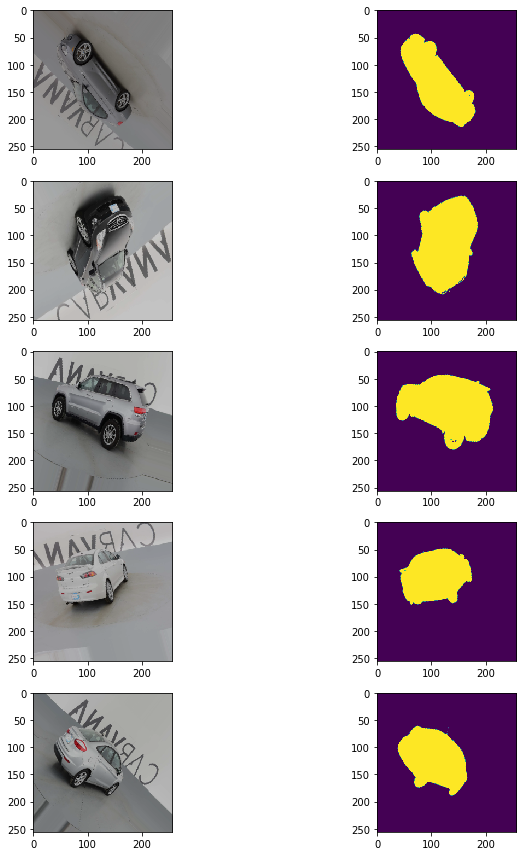

In [51]:
fig=plt.figure(figsize=(12,12))
columns = 2
rows = 5
counter = 0
c = 0
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img1[c])
    else:
        plt.imshow(mask1[c][:,:,0])
        c = c + 1
    counter = counter + 1
    

plt.tight_layout()
plt.savefig('augmented.png')
plt.show()

UNET

In [0]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras import backend as K

In [0]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
img_size = 256
im_width = 256
im_height = 256
im_chan = 3

In [54]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[dice_coef]) 
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_2[0][0]            

In [0]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='./logs/logs_1e-4')]


In [66]:
results = model.fit_generator(train_generator, steps_per_epoch=135, epochs=15, validation_data=validation_generator, validation_steps=16, callbacks=callbacks)

Epoch 1/15
135/135 [==============================] - 352s 3s/step - loss: 0.2232 - dice_coef: 0.6598 - val_loss: 0.4722 - val_dice_coef: 0.6430

Epoch 2/15
135/135 [==============================] - 330s 2s/step - loss: 0.2178 - dice_coef: 0.7178 - val_loss: 0.6282 - val_dice_coef: 0.5539
Epoch 3/15
135/135 [==============================] - 332s 2s/step - loss: 0.2077 - dice_coef: 0.7723 - val_loss: 0.6036 - val_dice_coef: 0.5384
Epoch 4/15
135/135 [==============================] - 330s 2s/step - loss: 0.2023 - dice_coef: 0.7933 - val_loss: 0.6560 - val_dice_coef: 0.5464
Epoch 5/15
135/135 [==============================] - 328s 2s/step - loss: 0.1978 - dice_coef: 0.7525 - val_loss: 0.6526 - val_dice_coef: 0.5383

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/15
135/135 [==============================] - 333s 2s/step - loss: 0.3145 - dice_coef: 0.5908 - val_loss: 0.3413 - val_dice_coef: 0.5161
Epoch 7/15
135/135 [===========================